In [1]:
import time
import pandas as pd

import bernielib as bl

In [2]:
bl.listSerialPorts()

['COM7', 'COM18', 'COM20']

In [3]:
ber = bl.robot(cartesian_port_name='COM18', pipette_port_name='COM7', misc_port_name='COM20')

In [4]:
ber.robotHome()
ber.pipetteHome()

# Actual protocol

In [5]:
# Experiment parameters
number_of_samples = 3
initial_volume_list = [0, 0, 0]
beads_incubation_time = 200 # seconds
beads_pull_time = 60 # seconds
ethanol_wash_time = 30 # seconds
ethanol_drying_time = 5*60 # seconds
V_ethanol_wash = 200 # uL

## Initializing samples and reagents

In [6]:
samples_list = bl.createSamplesToPurifyList(ber, initial_volume_list)
result_list = bl.createPurifiedSamplesList(ber, number_of_samples)

In [7]:
beads = bl.createSample('eppendorf', 'beads', ber.samples_rack, 0, 11, 800)
EtOH = bl.createSample('50ml', 'EtOH', ber.reagents_rack, 1, 0, 50000)
eluent = bl.createSample('50ml', 'eluent', ber.reagents_rack, 2, 0, 50000)
waste = bl.createSample('50ml', 'liquid_waste', ber.reagents_rack, 0, 1, 0)
water = bl.createSample('50ml', 'water', ber.reagents_rack, 1, 1, 50000)
EtOH80pct = bl.createSample('50ml', 'EtOH80pct', ber.reagents_rack, 2, 1, 50000)

### (technical) pre-filling the fake samples

This time, I am "purifying" the fake samples. Just filling them with water

In [8]:
def _prefillTubes(robot, samples_list, vol_list, water, safe_z=50):
    """
    This function is only used for testing. 
    It pre-fills empty tubes with water, to emulate the presence of the liquid.
    In a real protocol, samples already come with liquid.
    """
    robot.pickUpNextTip()
    robot.move(z=safe_z)
    for sample, volume in zip(samples_list, vol_list):
        robot.transferLiquid(water, sample, volume)
    robot.move(z=safe_z)
    robot.dumpTipToWaste()

In [9]:
_prefillTubes(ber, samples_list, [25, 50, 90], water)

## Calculating how many beads to add

In [13]:
def calcBeadsVolumeToAdd(robot, samples_list, cutoff_list):
    v_beads_list = []
    for sample, dna_size in zip(samples_list, cutoff_list):
        v_beads = robot.calcBeadsVol(sample, dna_size)
        v_beads_list.append(v_beads)
    return v_beads_list

In [14]:
v_beads_list = calcBeadsVolumeToAdd(ber, samples_list, cutoff_list=[100, 280, 900])

In [15]:
v_beads_list

[0.0, 0.0, 0.0]

## Adding beads

In [30]:
script = pd.read_csv('mixing_pattern_eppendorf.csv')

In [16]:
def waitAfterTimestamp(timestamp, delay):
    new_ts = time.time()
    while (new_ts - timestamp) < delay:
        time.sleep(1)
        new_ts = time.time()

In [11]:
def addBeads(robot, sample, beads, v_beads, sample_mix_scenario, beads_mix_scenario, z_safe=50):
    robot.move(z=z_safe)
    robot.pickUpNextTip()
    robot.move(z=z_safe)
    # Mixing beads before experiment
    robot.mixByScript(beads, beads_mix_scenario)
    # Transferring beads to sample
    robot.transferLiquid(beads, sample, v_beads)
    # Mixing sample with beads
    robot.mixByScript(sample, sample_mix_scenario)
    robot.move(z=z_safe)
    robot.dumpTipToWaste()
    robot.move(z=z_safe)

In [17]:
def addBeadsToAll(robot, samples_list, v_beads_list, beads, sample_mix_scenario, beads_mix_scenario):
    robot.moveMagnetsAway(poweroff=True)
    counter = 0
    for sample, v_beads in zip(samples_list, v_beads_list):
        addBeads(robot, sample, beads, v_beads, sample_mix_scenario, beads_mix_scenario)
        if counter == 0:
            timestamp = time.time()
        counter += 1
    return timestamp

In [ ]:
timestamp_beads_added = addBeadsToAll(ber, samples_list, v_beads_list, beads, script, script)

In [ ]:
waitAfterTimestamp(timestamp_beads_added, beads_incubation_time)

## Removing supernatant

In [14]:
ber.moveMagnetsTowardsTube()

In [ ]:
time.sleep(beads_pull_time)

In [12]:
def removeSupernatant(robot, sample, waste, z_safe=50):
    robot.pickUpNextTip()
    robot.move(z=z_safe)
    z0 = robot._getTubeZBottom(sample)
    while sample.getVolume() > 0:
        robot.movePipetteToVolume(200)
        robot.moveToSample(sample)
        robot.move(z=z0-0.5)
        robot.movePipetteToVolume(0)
        new_vol = sample.getVolume() - 200
        if new_vol < 0:
            new_vol = 0
        sample.setVolume(new_vol)
        robot.move(z=0)
        robot.dispenseLiquid(waste, 200, blow_extra=True)
        robot.move(z=0)
    robot.moveToSample(sample)
    robot.movePipetteToVolume(200)
    robot.move(z=z0)
    robot.movePipetteToVolume(150)
    robot.move(z=z0-0.5)
    robot.moveAxisDelta('X', 1.5)
    robot.movePipetteToVolume(130)
    robot.moveAxisDelta('X', -1.5)
    robot.moveAxisDelta('Y', 1.5)
    robot.movePipetteToVolume(100)
    robot.moveAxisDelta('Y', -1.5)
    robot.moveAxisDelta('X', -1.5)    
    robot.movePipetteToVolume(70)
    robot.moveAxisDelta('X', 1.5)
    robot.moveAxisDelta('Y', -1.5)
    robot.movePipetteToVolume(0)
    robot.move(z=z_safe)
    robot.dispenseLiquid(waste, 200, blow_extra=True)
    robot.move(z=z_safe)
    robot.dumpTipToWaste()

In [ ]:
def removeSupernatantAllSamples(robot, samples_list, waste):
    counter = 0
    for sample in samples_list:
        removeSupernatant(robot, sample, waste)
        if counter == 0:
            sample_dried_timestamp = time.time()
        counter += 0
    return sample_dried_timestamp

In [ ]:
ts = removeSupernatantAllSamples(ber, samples_list, waste)

## Ethanol wash, stage 1

In [ ]:
def add80PctEthanol(robot, samples_list, ethanol, volume, z_safe=50):
    robot.pickUpNextTip()
    robot.move(z=z_safe)
    
    counter = 0
    for sample in samples_list:
        robot.transferLiquid(ethanol, sample, volume, touch_wall=False)
        if counter == 0:
            ethanol_added_time = time.time()
        counter += 1
    
    robot.move(z=z_safe)
    robot.dumpTipToWaste()
    
    return ethanol_added_time

In [ ]:
timestamp_ethanol_added = add80PctEthanol(ber, samples_list, EtOH80pct, V_ethanol_wash)

In [ ]:
waitAfterTimestamp(timestamp_ethanol_added, ethanol_wash_time)

In [ ]:
ts = removeSupernatantAllSamples(ber, samples_list, waste)

## Ethanol wash, stage 2

In [ ]:
timestamp_ethanol_added = add80PctEthanol(ber, samples_list, EtOH80pct, V_ethanol_wash)
waitAfterTimestamp(timestamp_ethanol_added, ethanol_wash_time)
timestamp_ethanol_removed = removeSupernatantAllSamples(ber, samples_list, waste)

In [ ]:
waitAfterTimestamp(timestamp_ethanol_removed, ethanol_drying_time)

## Elution

In [22]:
ber.pickUpNextTip()
ber.move(z=0)

In [52]:
ber.moveMagnetsAway()

In [24]:
ber.transferLiquid(water, samples_list[0], 20)

In [13]:
def elutionMix(robot, sample, volume, delay=0.5):
    z0 = robot._getTubeZBottom(sample)
    robot.movePipetteToVolume(0)
    robot.movePipetteToVolume(volume+5)
    robot.movePipetteToVolume(volume)
    robot.move(z=z0-0.5)
    robot.movePipetteToVolume(0)
    time.sleep(delay)
    #z_curr = sample.calcAbsLiquidLevelFromVol(1700, added_length=robot._calcExtraLength())
    #robot.move(z=z_curr)
    #robot.moveAxisDelta('X', 4)
    #robot.movePipetteToVolume(200)
    z_curr = sample.calcAbsLiquidLevelFromVol(500, added_length=robot._calcExtraLength())
    robot.move(z=z_curr)
    robot.moveAxisDelta('X', 3)
    robot.movePipetteToVolume(200)
    time.sleep(delay)
    z_curr = sample.calcAbsLiquidLevelFromVol(300, added_length=robot._calcExtraLength())
    robot.move(z=z_curr)
    robot.moveAxisDelta('X', -1)
    z_curr = sample.calcAbsLiquidLevelFromVol(150, added_length=robot._calcExtraLength())
    robot.move(z=z_curr)
    robot.moveAxisDelta('X', -1)
    z_curr = sample.calcAbsLiquidLevelFromVol(10, added_length=robot._calcExtraLength())
    robot.move(z=z_curr)
    robot.moveAxisDelta('X', -1)
    z_curr = sample.calcAbsLiquidLevelFromVol(volume+100, added_length=robot._calcExtraLength())
    robot.move(z=z_curr)
    robot.movePipetteToVolume(0)

In [46]:
ber.moveToSample(samples_list[0])

In [35]:
elutionMix(ber, samples_list[0], 20)
elutionMix(ber, samples_list[0], 20)
elutionMix(ber, samples_list[0], 20)

In [13]:
ber.move(z=50)

In [37]:
ber.moveMagnetsTowardsTube()

In [41]:
result_list = bl.createPurifiedSamplesList(ber, 1)

In [47]:
ber.movePipetteToVolume(25)
ber.movePipetteToVolume(20)
z0 = ber._getTubeZBottom(samples_list[0])
ber.move(z=z0-0.5)
ber.movePipetteToVolume(0)

In [48]:
ber.moveToSample(result_list[0])

In [49]:
ber.movePipetteToVolume(200)

In [42]:
ber.transferLiquid(samples_list[0], result_list[0], 100)

In [51]:
ber.transferLiquid(water, samples_list[0], 400, touch_wall=False)

In [14]:
ber.dumpTipToWaste()

### Adding eluent in one function

In [14]:
#TODO: make safe_z a general property of the robot
def elute(robot, sample, eluent, volume, mix_delay=0.5, mix_times=6, safe_z=50):
    robot.moveMagnetsAway(poweroff=True)
    robot.pickUpNextTip()
    robot.move(z=safe_z)
    robot.transferLiquid(eluent, sample, volume)
    for i in range(mix_times):
        elutionMix(robot, sample, volume)
    elution_start_time = time.time()
    robot.move(z=safe_z)
    robot.dumpTipToWaste()
    return elution_start_time

In [1]:
def eluteAllSamples(robot, samples_list, eluent, volume, mix_delay=0.5, mix_times=6, safe_z=50):
    counter = 0
    for sample in samples_list:
        ts = elute(ber, sample, water, V_water, mix_delay=mix_delay, mix_times=mix_times, safe_z=safe_z)
        if counter == 0:
            elution_start_timestamp = ts
        counter += 1
    return elution_start_timestamp

In [9]:
elute(ber, samples_list[0], water, 20)

1607418080.4168348

In [18]:
elute(ber, samples_list[2], water, 30)

1607560476.0005112

### Separate eluate from beads (one function)

In [15]:
def separateEluate(robot, eluate_tube, result_tube, pipette_delay=0.5, z_above_bottom=0.5, safe_z=50):
    robot.pickUpNextTip()
    robot.move(z=safe_z)
    # Uptaking liquid
    v = eluate_tube.getVolume()
    robot.moveToSample(eluate_tube)
    robot.movePipetteToVolume(v+5)
    robot.movePipetteToVolume(v)
    z0 = robot._getTubeZBottom(eluate_tube)
    robot.move(z=z0-z_above_bottom)
    robot.movePipetteToVolume(0)
    time.sleep(pipette_delay)
    # Dispensing liquid
    robot.moveToSample(result_tube)
    robot.movePipetteToVolume(v+5)
    time.sleep(pipette_delay)
    robot.movePipetteToVolume(200)
    time.sleep(pipette_delay)
    robot.touchWall(result_tube)
    robot.movePipetteToVolume(0)
    robot.move(z=safe_z)
    ber.dumpTipToWaste()

In [15]:
result_list = bl.createPurifiedSamplesList(ber, 1)

In [16]:
separateEluate(ber, samples_list[0], result_list[0])

## Full elution process

In [10]:
samples_list = bl.createSamplesToPurifyList(ber, [0, 0, 0])
result_list = bl.createPurifiedSamplesList(ber, 3)

In [13]:
# Elution
# Parameters
V_water = 30
T_elute = 200 # seconds, 10 minutes
T_magnets_on = 60 # seconds

# Adding water
counter = 0
for sample in samples_list:
    ts = elute(ber, sample, water, V_water)
    if counter == 0:
        elution_start_timestamp = ts
    counter += 1

waitAfterTimestamp(elution_start_timestamp, T_elute) # elution wait

# Magnetic beads to the side of the tubes
ber.moveMagnetsTowardsTube()

time.sleep(T_magnets_on)

# Moving liquid to the resulting tubes
for sample, result in zip(samples_list, result_list):
    separateEluate(ber, sample, result)

# All in one function

In [10]:
def calcBeadsVolumeToAdd(robot, samples_list, cutoff_list):
    v_beads_list = []
    for sample, dna_size in zip(samples_list, cutoff_list):
        v_beads = robot.calcBeadsVol(sample, dna_size)
        v_beads_list.append(v_beads)
    return v_beads_list

In [11]:
def waitAfterTimestamp(timestamp, delay):
    new_ts = time.time()
    while (new_ts - timestamp) < delay:
        time.sleep(1)
        new_ts = time.time()

In [12]:
def addBeads(robot, sample, beads, v_beads, sample_mix_scenario, beads_mix_scenario, z_safe=50):
    robot.move(z=z_safe)
    #robot.pickUpNextTip()
    #robot.move(z=z_safe)
    # Mixing beads before experiment
    #robot.mixByScript(beads, beads_mix_scenario)
    # Transferring beads to sample
    robot.transferLiquid(beads, sample, v_beads)
    # Mixing sample with beads
    robot.mixByScript(sample, sample_mix_scenario)
    robot.move(z=z_safe)
    #robot.dumpTipToWaste()
    robot.move(z=z_safe)

In [13]:
def addBeadsToAll(robot, samples_list, v_beads_list, beads, sample_mix_scenario, beads_mix_scenario):
    robot.moveMagnetsAway(poweroff=True)
    robot.pickUpNextTip()
    robot.mixByScript(beads, beads_mix_scenario)
    
    for sample, v_beads in zip(samples_list, v_beads_list):
        robot.transferLiquid(beads, sample, v_beads)
    
    counter = 0
    for sample, v_beads in zip(samples_list, v_beads_list):
        if counter != 0:
            robot.pickUpNextTip()
        
        robot.mixByScript(sample, sample_mix_scenario)
    
        if counter == 0:
            timestamp = time.time()
        counter += 1
        robot.dumpTipToWaste()
    
    return timestamp

In [14]:
def removeSupernatant(robot, sample, waste, z_safe=50):
    robot.pickUpNextTip()
    robot.move(z=z_safe)
    z0 = robot._getTubeZBottom(sample)
    while sample.getVolume() > 0:
        robot.movePipetteToVolume(200)
        robot.moveToSample(sample)
        robot.move(z=z0-0.5)
        robot.movePipetteToVolume(0)
        new_vol = sample.getVolume() - 200
        if new_vol < 0:
            new_vol = 0
        sample.setVolume(new_vol)
        robot.move(z=0)
        robot.dispenseLiquid(waste, 200, blow_extra=True)
        robot.move(z=0)
    robot.moveToSample(sample)
    robot.movePipetteToVolume(200)
    robot.move(z=z0)
    robot.movePipetteToVolume(150)
    robot.move(z=z0-0.5)
    robot.moveAxisDelta('X', 1.5)
    robot.movePipetteToVolume(130)
    robot.moveAxisDelta('X', -1.5)
    robot.moveAxisDelta('Y', 1.5)
    robot.movePipetteToVolume(100)
    robot.moveAxisDelta('Y', -1.5)
    robot.moveAxisDelta('X', -1.5)    
    robot.movePipetteToVolume(70)
    robot.moveAxisDelta('X', 1.5)
    robot.moveAxisDelta('Y', -1.5)
    robot.movePipetteToVolume(0)
    robot.move(z=z_safe)
    robot.dispenseLiquid(waste, 200, blow_extra=True)
    robot.move(z=z_safe)
    robot.dumpTipToWaste()

In [15]:
def removeSupernatantAllSamples(robot, samples_list, waste):
    counter = 0
    for sample in samples_list:
        removeSupernatant(robot, sample, waste)
        if counter == 0:
            sample_dried_timestamp = time.time()
        counter += 0
    return sample_dried_timestamp

In [16]:
def add80PctEthanol(robot, samples_list, ethanol, volume, z_safe=50):
    robot.pickUpNextTip()
    robot.move(z=z_safe)
    
    counter = 0
    for sample in samples_list:
        robot.transferLiquid(ethanol, sample, volume, touch_wall=False)
        if counter == 0:
            ethanol_added_time = time.time()
        counter += 1
    
    robot.move(z=z_safe)
    robot.dumpTipToWaste()
    
    return ethanol_added_time

In [17]:
def elutionMix(robot, sample, volume, delay=0.5):
    z0 = robot._getTubeZBottom(sample)
    robot.movePipetteToVolume(0)
    robot.movePipetteToVolume(volume+5)
    robot.movePipetteToVolume(volume)
    robot.move(z=z0-0.5)
    robot.movePipetteToVolume(0)
    time.sleep(delay)
    #z_curr = sample.calcAbsLiquidLevelFromVol(1700, added_length=robot._calcExtraLength())
    #robot.move(z=z_curr)
    #robot.moveAxisDelta('X', 4)
    #robot.movePipetteToVolume(200)
    z_curr = sample.calcAbsLiquidLevelFromVol(500, added_length=robot._calcExtraLength())
    robot.move(z=z_curr)
    robot.moveAxisDelta('X', 3)
    robot.movePipetteToVolume(200)
    time.sleep(delay)
    z_curr = sample.calcAbsLiquidLevelFromVol(300, added_length=robot._calcExtraLength())
    robot.move(z=z_curr)
    robot.moveAxisDelta('X', -1)
    z_curr = sample.calcAbsLiquidLevelFromVol(150, added_length=robot._calcExtraLength())
    robot.move(z=z_curr)
    robot.moveAxisDelta('X', -1)
    z_curr = sample.calcAbsLiquidLevelFromVol(10, added_length=robot._calcExtraLength())
    robot.move(z=z_curr)
    robot.moveAxisDelta('X', -1)
    z_curr = sample.calcAbsLiquidLevelFromVol(volume+100, added_length=robot._calcExtraLength())
    robot.move(z=z_curr)
    robot.movePipetteToVolume(0)

In [18]:
#TODO: make safe_z a general property of the robot
def elute(robot, sample, eluent, volume, mix_delay=0.5, mix_times=6, safe_z=50):
    robot.moveMagnetsAway(poweroff=True)
    robot.pickUpNextTip()
    robot.move(z=safe_z)
    robot.transferLiquid(eluent, sample, volume)
    for i in range(mix_times):
        elutionMix(robot, sample, volume)
    elution_start_time = time.time()
    robot.move(z=safe_z)
    robot.dumpTipToWaste()
    return elution_start_time

In [19]:
def eluteAllSamples(robot, samples_list, eluent, V_eluent, mix_delay=0.5, mix_times=6, safe_z=50):
    counter = 0
    for sample in samples_list:
        ts = elute(ber, sample, eluent, V_eluent, mix_delay=mix_delay, mix_times=mix_times, safe_z=safe_z)
        if counter == 0:
            elution_start_timestamp = ts
        counter += 1
    return elution_start_timestamp

In [20]:
def separateEluate(robot, eluate_tube, result_tube, pipette_delay=0.5, z_above_bottom=0.5, safe_z=50):
    robot.pickUpNextTip()
    robot.move(z=safe_z)
    # Uptaking liquid
    v = eluate_tube.getVolume()
    robot.moveToSample(eluate_tube)
    robot.movePipetteToVolume(v+5)
    robot.movePipetteToVolume(v)
    z0 = robot._getTubeZBottom(eluate_tube)
    robot.move(z=z0-z_above_bottom)
    robot.movePipetteToVolume(0)
    time.sleep(pipette_delay)
    # Dispensing liquid
    robot.moveToSample(result_tube)
    robot.movePipetteToVolume(v+5)
    time.sleep(pipette_delay)
    robot.movePipetteToVolume(200)
    time.sleep(pipette_delay)
    robot.touchWall(result_tube)
    robot.movePipetteToVolume(0)
    robot.move(z=safe_z)
    ber.dumpTipToWaste()

In [21]:
def oneStagePurification(robot, N_samples, initial_vol_list, cutoff_list, V_avail_beads, V_avail_water, V_avail_ethanol, 
                         beads_rack, beads_col, beads_row, sample_mix_scenario, beads_mix_scenario,
                         V_waste=0, T_absorb=600, T_pull=60, T_wash=30, T_dry=300, T_elute=600,
                         V_wash=200, V_elute=30):
    
    samples_list = bl.createSamplesToPurifyList(robot, initial_vol_list)
    result_list = bl.createPurifiedSamplesList(robot, N_samples)
    beads = bl.createSample('eppendorf', 'beads', beads_rack, beads_col, beads_row, V_avail_beads)
    waste = bl.createSample('50ml', 'liquid_waste', ber.reagents_rack, 0, 1, V_waste)
    water = bl.createSample('50ml', 'water', ber.reagents_rack, 1, 1, V_avail_water)
    EtOH80pct = bl.createSample('50ml', 'EtOH80pct', ber.reagents_rack, 2, 1, V_avail_ethanol)
    
    v_beads_list = calcBeadsVolumeToAdd(robot, samples_list, cutoff_list=cutoff_list)
    # Adding beads
    timestamp_beads_added = addBeadsToAll(robot, samples_list, v_beads_list, beads, sample_mix_scenario, beads_mix_scenario)
    waitAfterTimestamp(timestamp_beads_added, T_absorb)
    # Removing supernatant
    robot.moveMagnetsTowardsTube(poweroff=True)
    time.sleep(T_pull)
    ts = removeSupernatantAllSamples(robot, samples_list, waste)
    # Ethanol wash
    # Wash 1
    timestamp_ethanol_added = add80PctEthanol(robot, samples_list, EtOH80pct, V_wash)
    waitAfterTimestamp(timestamp_ethanol_added, T_wash)
    ts = removeSupernatantAllSamples(robot, samples_list, waste)
    # Wash 2
    timestamp_ethanol_added = add80PctEthanol(robot, samples_list, EtOH80pct, V_wash)
    waitAfterTimestamp(timestamp_ethanol_added, T_wash)
    timestamp_ethanol_removed = removeSupernatantAllSamples(robot, samples_list, waste)
    # Drying ethanol
    waitAfterTimestamp(timestamp_ethanol_removed, T_dry)
    
    # Elution
    # Adding water
    elution_start_timestamp = eluteAllSamples(robot, samples_list, water, V_elute, mix_delay=0.5, mix_times=6, safe_z=50)
    waitAfterTimestamp(elution_start_timestamp, T_elute) # elution wait
    
    # Magnetic beads to the side of the tubes
    ber.moveMagnetsTowardsTube()
    time.sleep(T_pull)
    # Moving liquid to the resulting tubes
    for sample, result in zip(samples_list, result_list):
        separateEluate(ber, sample, result)

In [22]:
script = pd.read_csv('mixing_pattern_eppendorf.csv')

In [23]:
ber.tips_rack.refill()

In [ ]:
oneStagePurification(ber, N_samples=3, initial_vol_list=[25, 50, 90], cutoff_list=[100, 280, 900],
                     V_avail_beads=1000, V_avail_water=50000, V_avail_ethanol=50000, 
                     beads_rack=ber.samples_rack, beads_col=0, beads_row=11, 
                     sample_mix_scenario=script, beads_mix_scenario=script)

In [ ]:
# poweroff doesn't work (doesn't bring magnets after absorbing )

# Other commands, not part of the protocol

In [7]:
ber.tips_rack.refill()

In [44]:
ber.move(z=0)

In [34]:
ber.dumpTipToWaste()

In [14]:
ber.move(z=180)

In [15]:
for i in range(100):
    ber.move(z=0)
    ber.move(z=180)

KeyboardInterrupt: 

In [47]:
ber.move(x=0)

In [46]:
ber.move(x=180)

In [54]:
ber.pickUpNextTip()

In [55]:
ber.dumpTipToWaste()

In [6]:
for i in range(10):
    ber.moveToWell(rack_name='tips', column=0, row=0, save_height=10)
    ber.moveDownUntilPress(1, 4000)
    ber.moveAxisDelta('Z', -20)
    ber.dumpTip()
    ber.move(z=0)
    ber.move(x=0)
    time.sleep(1)
    ber.move(x=180)
    time.sleep(1)

In [7]:
ber.moveMagnetsTowardsTube(poweroff=True)

In [8]:
ber.moveMagnetsAway(poweroff=True)

In [56]:
samples_list = bl.createSamplesToPurifyList(ber, initial_volume_list)
result_list = bl.createPurifiedSamplesList(ber, number_of_samples)

In [58]:
elution_start_timestamp = eluteAllSamples(ber, samples_list, water, 30, mix_delay=0.5, mix_times=6, safe_z=50)

# water touching with sensors

In [21]:
ber.pickUpNextTip()

In [36]:
ber.move(z=50)

In [23]:
water = bl.createSample('50ml', 'water', ber.reagents_rack, 1, 1, 50000)
empty = bl.createSample('50ml', 'empty', ber.reagents_rack, 1, 0, 0)

In [37]:
ber.moveToSample(empty)

In [25]:
ber.getPosition(axis='Z')

66.3

In [28]:
ber.move(z=100)

In [29]:
range?

In [38]:
z_vs_press_dict = {}
ber.move(z=66)
ber.tareAll()
for i in range(66, 100, 1):
    ber.move(z=i)
    time.sleep(1)
    z_vs_press_dict[i] = ber.getCombinedLoad()

In [39]:
z_vs_press_dict

{66: -0.05,
 67: 0.03000000000000025,
 68: -0.10999999999999999,
 69: 0.15999999999999992,
 70: 0.2999999999999998,
 71: 0.5199999999999996,
 72: 0.8500000000000005,
 73: 1.3599999999999999,
 74: 1.5299999999999998,
 75: 2.08,
 76: 2.25,
 77: 2.48,
 78: 2.74,
 79: 2.6500000000000004,
 80: 2.57,
 81: 2.6800000000000006,
 82: 2.3999999999999995,
 83: 2.62,
 84: 2.4499999999999997,
 85: 2.28,
 86: 2.33,
 87: 2.6599999999999997,
 88: 2.9000000000000004,
 89: 3.29,
 90: 3.46,
 91: 3.719999999999999,
 92: 4.03,
 93: 4.21,
 94: 4.18,
 95: 4.170000000000001,
 96: 4.199999999999999,
 97: 4.24,
 98: 3.88,
 99: 3.7499999999999996}

In [40]:
ber.moveToSample(water)

In [42]:
z_vs_press_dict_water = {}
ber.move(z=66)
ber.tareAll()
for i in range(66, 100, 1):
    ber.move(z=i)
    time.sleep(1)
    z_vs_press_dict_water[i] = ber.getCombinedLoad()

In [43]:
z_vs_press_dict_water

{66: -3.8600000000000003,
 67: -3.5100000000000002,
 68: -3.37,
 69: -2.99,
 70: -2.92,
 71: -2.54,
 72: -2.0200000000000005,
 73: -1.4699999999999998,
 74: -1.45,
 75: -0.7,
 76: -0.11000000000000032,
 77: -0.07000000000000028,
 78: -0.08999999999999986,
 79: -0.10000000000000009,
 80: -0.14,
 81: 0.17000000000000082,
 82: 0.1499999999999999,
 83: 0.0900000000000003,
 84: -0.040000000000000036,
 85: -0.10999999999999999,
 86: 0.22999999999999998,
 87: 0.47,
 88: 0.89,
 89: 1.1600000000000001,
 90: 1.45,
 91: 1.5999999999999999,
 92: 1.8599999999999999,
 93: 1.9300000000000002,
 94: 2.13,
 95: 2.19,
 96: 2.43,
 97: 2.26,
 98: 2.02,
 99: 1.83}

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
df = pd.DataFrame({'empty': z_vs_press_dict, 'water': z_vs_press_dict_water})

In [46]:
df

,empty,water
66,-0.05,-3.86
67,0.03,-3.51
68,-0.11,-3.37
69,0.16,-2.99
70,0.30,-2.92
71,0.52,-2.54
72,0.85,-2.02
73,1.36,-1.47
74,1.53,-1.45
75,2.08,-0.70


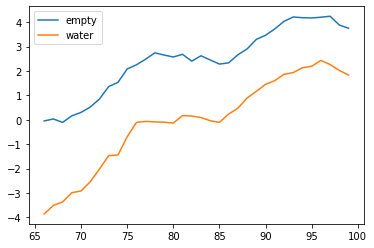

In [50]:
df.plot()

In [52]:
ber.dumpTipToWaste()